# Autoencoders - Aula Prática

## Configurações

Importando módulos necessários

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torchsummary import summary

## Introdução

Autoencoders são modelos que aprendem a representação de dados de entrada. Eles são compostos por duas partes: um encoder e um decoder. O encoder é responsável por mapear a entrada para um espaço latente, enquanto o decoder é responsável por mapear o espaço latente para a saída. A ideia é que o espaço latente seja uma representação mais compacta e significativa dos dados de entrada.

Nesta aula prática, vamos implementar um autoencoder para reconstruir imagens do dataset MNIST e entender como esse tipo de modelo funciona

## Carregando o dataset

Vamos começar carregando o dataset MNIST. O dataset é composto por imagens de dígitos escritos à mão, com dimensões 28x28 pixels.

In [2]:
"""
Como queremos que o autoencoder aprenda a reconstruir a imagem de entrada,
reformulamos o dataset MNIST para que ele retorne a mesma imagem como entrada e saída.
"""
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [3]:
mnist_train_ds = AutoencoderMNIST(
    "./data/mnist",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    return_labels=True
)
mnist_test_ds = AutoencoderMNIST(
    "./data/mnist",
    train=False,
    transform=transforms.ToTensor()
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


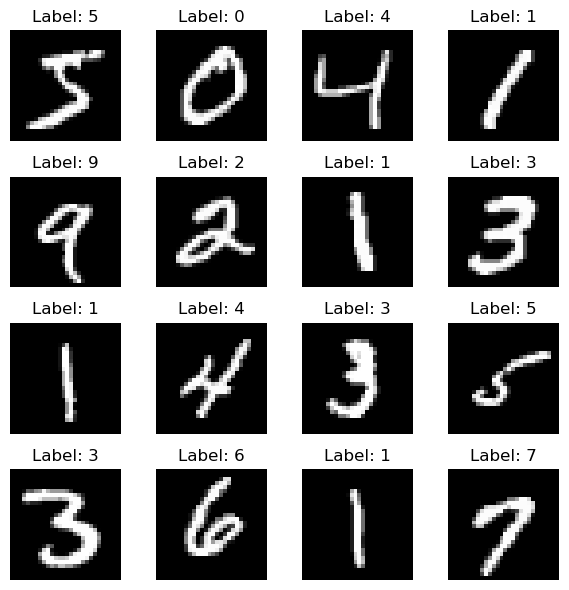

In [4]:
# Plot the first 16 images from the MNIST dataset
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i == 0:
        print(f"image shape: {mnist_train_ds[i][0].shape}")
    image, _, label = mnist_train_ds[i]
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Implementando o autoencoder

Vamos implementar um autoencoder convolucional simples, com 3 camadas convolucionais no encoder e 3 camadas convolucionais no decoder. A arquitetura do autoencoder é a seguinte:

- Encoder:
    - Conv2D com 16 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - MaxPooling2D com pool size 2x2
    - Conv2D com 8 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - MaxPooling2D com pool size 2x2
    - Conv2D com 2 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - Camada Linear que mapeia os features maps para o espaço latente

- Decoder:
    - Camada Linear que mapeia o espaço latente para os features maps
    - Conv2D com 128 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - UpSampling2D com size 2x2
    - Conv2D com 64 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - UpSampling2D com size 2x2
    - Conv2D com 32 filtros, kernel de tamanho 3x3, função de ativação ReLU
    - Conv2D com 1 filtro, kernel de tamanho 3x3, função de ativação sigmoid

O tamanho do espaço latente é 2 para que possamos visualizar a representação dos dados no espaço latente.

In [5]:
class ConvolutionalEncoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(ConvolutionalEncoder, self).__init__()
        self.latent_size = latent_size

        # reduzimos o tamanho da imagem
        # considerando input (n_channels, 28, 28)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 16, 3, padding=1), # (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # (16, 14, 14)
            nn.Conv2d(16, 8, 3, padding=1), # (8, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (8, 7, 7)
            nn.Conv2d(8, 2, 3, padding=1), # (2, 7, 7)
            nn.ReLU(),
        )

        # extraimos as features da imagem reduzida
        self.flatten = nn.Flatten() # (2 * 7 * 7,) = (98,)

        # finalmente fazemos o encoding da nossa imagem em um vetor n dimensional
        self.encoder = nn.Linear(98, self.latent_size)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.encoder(x)
        return x

In [6]:
class ConvolutionalDecoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(ConvolutionalDecoder, self).__init__()
        self.latent_size = latent_size

        # decodificamos a representação latente para uma imagem 7x7
        self.decoder = nn.Linear(self.latent_size, 98)
        self.unflatten = nn.Unflatten(1, (2, 7, 7)) # (2, 7, 7)

        # voltamos a imagem ao tamanho original
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1), # (8, 7, 7)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (8, 14, 14)
            nn.Conv2d(8, 16, 3, padding=1), # (16, 14, 14)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (16, 28, 28)
            nn.Conv2d(16, n_channels, 3, padding=1), # (n_channels, 28, 28)
            nn.Sigmoid(), # sigmoid na última camada para que o output esteja no intervalo [0, 1]
        )

    def forward(self, x):
        x = self.decoder(x)
        x = self.unflatten(x)
        x = self.conv_layers(x)
        return x

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(Autoencoder, self).__init__()
        self.encoder = ConvolutionalEncoder(latent_size, n_channels)
        self.decoder = ConvolutionalDecoder(latent_size, n_channels)

    def forward(self, x, return_latent=False):
        latent = self.encoder(x)
        x = self.decoder(latent)

        return (x, latent) if return_latent else x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder(latent_size=2, n_channels=1)
autoencoder.to(device)
summary(autoencoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
            Conv2d-7              [-1, 2, 7, 7]             146
              ReLU-8              [-1, 2, 7, 7]               0
           Flatten-9                   [-1, 98]               0
           Linear-10                    [-1, 2]             198
ConvolutionalEncoder-11                    [-1, 2]               0
           Linear-12                   [-1, 98]             294
        Unflatten-13              [-1, 2, 7, 7]               0
           Conv2d-14              [-

## Treinando o autoencoder

Vamos treinar o autoencoder para reconstruir imagens do dataset MNIST. O autoencoder será treinado por 50 épocas, com batch size 128 e otimizador Adam.

In [10]:
def train(model, optimizer, loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            loss = loss_fn(outputs, targets)
            loss /= inputs.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss/(i+1):.4f}")

        train_loss /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)
                    loss /= inputs.size(0)

                    val_loss += loss.item()

            val_loss /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}")

In [11]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [12]:
autoencoder = Autoencoder(latent_size=2, n_channels=1)

In [13]:
epochs = 20
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(autoencoder, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 57.7847 | Val Loss: 43.5669


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 42.6506 | Val Loss: 41.7431


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 41.6092 | Val Loss: 41.0881


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 41.0392 | Val Loss: 40.6102


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 40.4958 | Val Loss: 40.0460


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 40.0787 | Val Loss: 39.6458


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 39.7752 | Val Loss: 39.4335


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 39.5342 | Val Loss: 39.1574


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 39.3456 | Val Loss: 38.9490


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 39.1212 | Val Loss: 38.7126


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 38.9458 | Val Loss: 38.5268


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 38.7489 | Val Loss: 38.4297


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 38.5782 | Val Loss: 38.1788


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 38.4195 | Val Loss: 38.0139


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 38.2766 | Val Loss: 38.0067


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 38.1492 | Val Loss: 37.8886


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 38.0052 | Val Loss: 37.7079


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 37.9214 | Val Loss: 37.6489


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 37.8084 | Val Loss: 37.4438


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 37.7140 | Val Loss: 37.2526


## Analisando os resultados

Nessa etapa, vamos analisar os resultados obtidos pelo autoencoder. Vamos visualizar as imagens de entrada e as imagens reconstruídas pelo autoencoder. Além disso, vamos visualizar a representação dos dados no espaço latente.

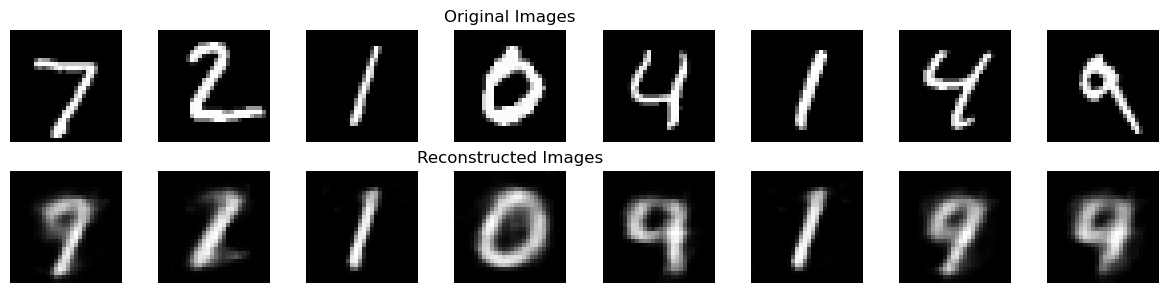

In [14]:
# Get some images from the test dataset
data_iter = iter(test_dl)
images, _ = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(12, 3))

for i in range(8):
    # Original images
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    # Reconstructed images
    ax = axes[1, i]
    ax.imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images')

plt.tight_layout()
plt.show()

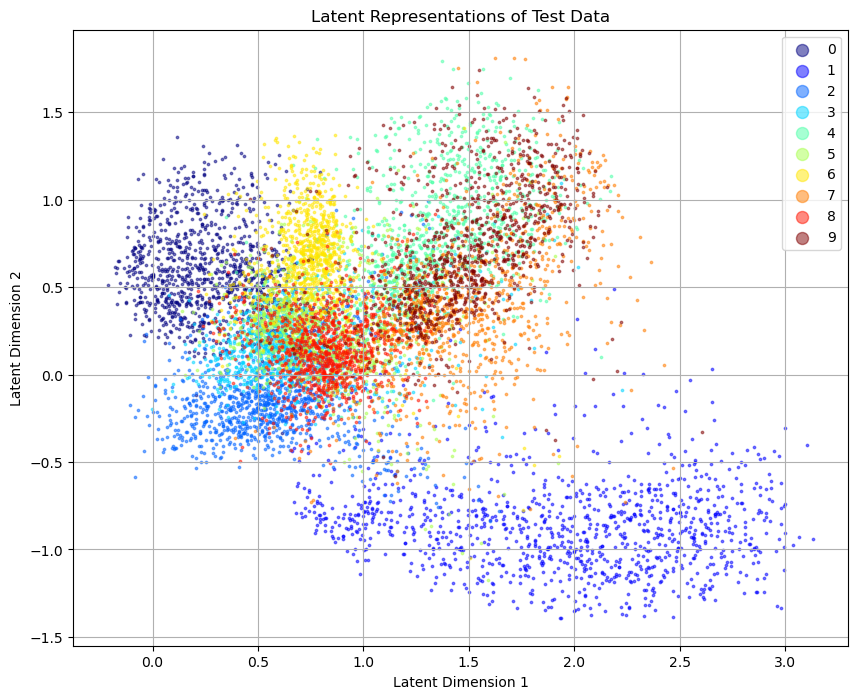

In [15]:
# Get the latent representations for all test data
latent_representations = []
labels_agg = []
digits = list(range(10))

mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(mnist_test_ds, batch_size=128)

autoencoder.eval()
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = autoencoder.encoder(images)
        latent_representations.append(latent_vectors.cpu().numpy())
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations = np.concatenate(latent_representations, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('jet', 10)
for d in digits:
    indices = np.where(labels_agg == d)
    plt.scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{d}",
        c=[cmap(d)],
        alpha=0.5,
    )
# add the labels mapping
plt.legend(markerscale=5)
plt.title('Latent Representations of Test Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

Observe que os digitos estão organizados no espaço latente de acordo com suas características. Por exemplo, os digitos 0 e 1 estão distantes, enquanto os digitos 3 e 8 estão juntos. Isso mostra que o autoencoder aprendeu a representação dos dados de forma significativa.

# Exercícios

## Exercício 1 - Denoising Autoencoder

Tendo em vista que o autoencoder é capaz de aprender a representação dos dados, podemos utilizá-lo para remover ruídos das imagens. Implemente um denoising autoencoder, que recebe imagens com ruídos como entrada e tenta reconstruir a imagem original.

<details>
<summary>Dica:</summary>
Você só vai precisar de mexer no dataset de entrada, adicionando ruídos às imagens.
</details>

In [16]:
import torchvision.transforms.v2 as v2

mnist_train_ds = AutoencoderMNIST(
    "./data/mnist",
    train=True,
    transform=transforms.ToTensor(),
    input_transform=v2.GaussianNoise(0, 0.1),
    return_labels=True,
    download=True,
)
mnist_test_ds = AutoencoderMNIST(
    "./data/mnist",
    train=False,
    transform=transforms.ToTensor(),
    input_transform=v2.GaussianNoise(0, 0.1)
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


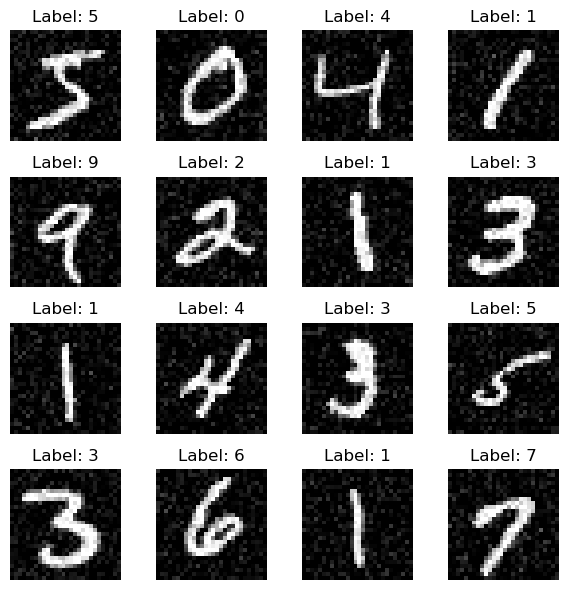

In [17]:
# Plot the first 16 images from the MNIST dataset
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i == 0:
        print(f"image shape: {mnist_train_ds[i][0].shape}")
    image, _, label = mnist_train_ds[i]
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [18]:
denoising_autoencoder = Autoencoder(latent_size=2, n_channels=1)

In [19]:
epochs = 20

mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(denoising_autoencoder.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(denoising_autoencoder, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 100.8841 | Val Loss: 61.9413


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 56.7947 | Val Loss: 54.8335


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 53.9954 | Val Loss: 53.6793


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 53.1697 | Val Loss: 53.0339


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 52.3215 | Val Loss: 52.0290


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 51.2408 | Val Loss: 50.8654


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 49.8097 | Val Loss: 49.3489


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 48.7639 | Val Loss: 48.4999


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 47.9381 | Val Loss: 47.5997


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 47.0728 | Val Loss: 46.6816


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 46.2293 | Val Loss: 45.8969


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 45.5071 | Val Loss: 45.2237


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 44.9707 | Val Loss: 44.7396


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 44.6160 | Val Loss: 44.3684


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 44.3456 | Val Loss: 44.1329


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 44.1431 | Val Loss: 43.9349


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 43.9719 | Val Loss: 43.7681


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 43.8302 | Val Loss: 43.6366


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 43.6936 | Val Loss: 43.5003


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 43.5901 | Val Loss: 43.3631


Loss for image 1: 39.109619140625
Loss for image 2: 57.105674743652344
Loss for image 3: 12.768580436706543
Loss for image 4: 38.86280822753906
Loss for image 5: 31.840469360351562
Loss for image 6: 12.466793060302734
Loss for image 7: 40.2852783203125
Loss for image 8: 41.397605895996094


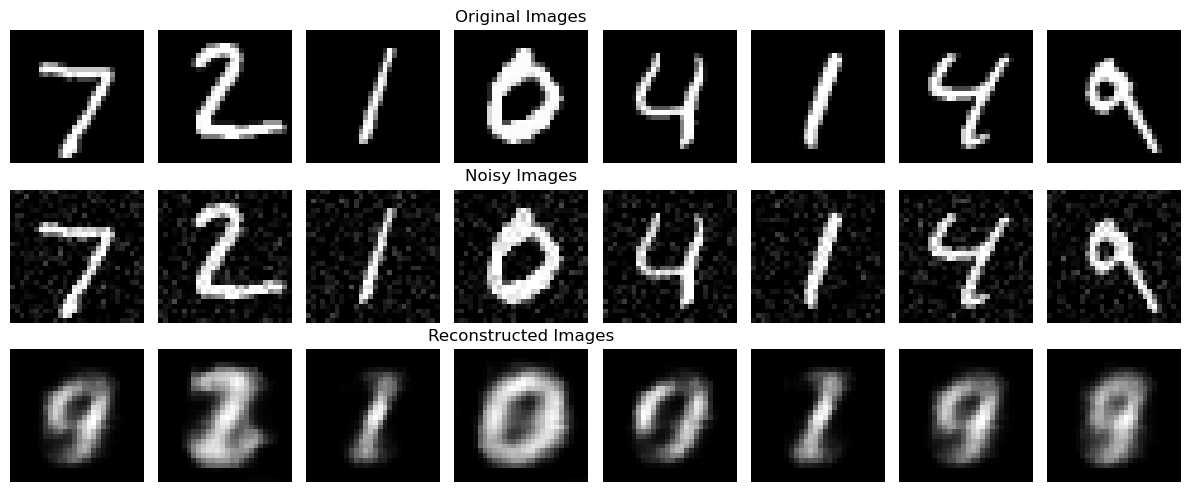

In [20]:
# Get some images from the test dataset
data_iter = iter(test_dl)
images, images_no_noise = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
denoising_autoencoder.eval()
with torch.no_grad():
    reconstructions = denoising_autoencoder(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(3, 8, figsize=(12, 5))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images_no_noise[i].squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    # Original images
    ax = axes[1, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Noisy Images')

    # Reconstructed images
    ax = axes[2, i]
    ax.imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images')

    loss = criterion(reconstructions[i], images[i])
    print(f"Loss for image {i+1}: {loss.item()}")

plt.tight_layout()
plt.show()

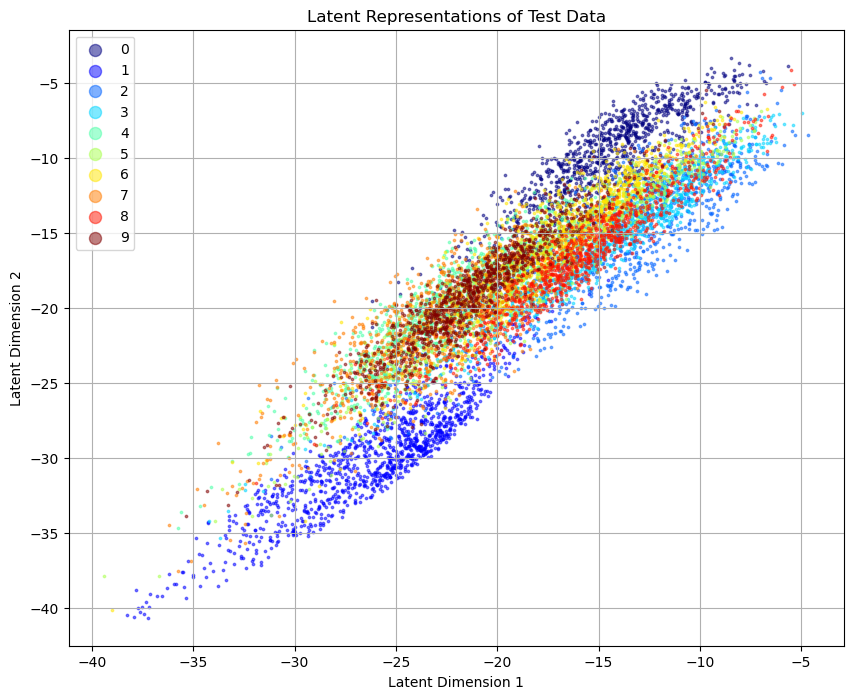

In [21]:
# Get the latent representations for all test data
latent_representations = []
labels_agg = []
digits = list(range(10))

mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(mnist_test_ds, batch_size=128)

denoising_autoencoder.eval()
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = denoising_autoencoder.encoder(images)
        latent_representations.append(latent_vectors.cpu().numpy())
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations = np.concatenate(latent_representations, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('jet', 10)
for d in digits:
    indices = np.where(labels_agg == d)
    plt.scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{d}",
        c=[cmap(d)],
        alpha=0.5,
    )
# add the labels mapping
plt.legend(markerscale=5)
plt.title('Latent Representations of Test Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

## Exercício 2 - Autoencoder com regularização

Implemente um autoencoder com regularização no espaço latente. Adicione uma regularização L1 ou L2 no espaço latente e treine o autoencoder.

<details>
<summary>Dica:</summary>
Altere a função de treino para aceitar mais um parâmetro, que será a regularização no espaço latente.
</details>

Tamanho do dataset de (treino, teste): (60000, 10000)
image shape: torch.Size([1, 28, 28])


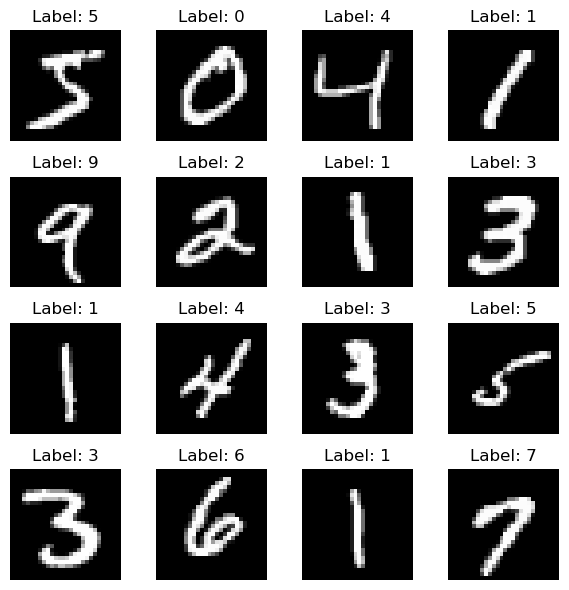

In [22]:
mnist_train_ds = AutoencoderMNIST(
    "./data/mnist",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    return_labels=True
)
mnist_test_ds = AutoencoderMNIST(
    "./data/mnist",
    train=False,
    transform=transforms.ToTensor()
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)
# Plot the first 16 images from the MNIST dataset
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i == 0:
        print(f"image shape: {mnist_train_ds[i][0].shape}")
    image, _, label = mnist_train_ds[i]
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [23]:
def train(model, optimizer, loss_fn, reg_loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_reconstruction_loss = 0.0
        train_regularization_loss = 0.0

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs, latent = model(inputs, return_latent=True)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            reconstruction_loss = loss_fn(outputs, targets)
            reconstruction_loss /= inputs.size(0)
            train_reconstruction_loss += reconstruction_loss.item()

            regularization_loss = reg_loss_fn(latent)
            regularization_loss /= inputs.size(0)
            train_regularization_loss += regularization_loss.item()

            loss = reconstruction_loss + regularization_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss/(i+1):.4f}")

        train_loss /= len(train_loader)
        train_reconstruction_loss /= len(train_loader)
        train_regularization_loss /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_reconstruction_loss = 0.0
            val_regularization_loss = 0.0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs, latent = model(inputs, return_latent=True)
                    reconstruction_loss = loss_fn(outputs, targets)
                    reconstruction_loss /= inputs.size(0)
                    val_reconstruction_loss += reconstruction_loss.item()

                    regularization_loss = reg_loss_fn(latent)
                    regularization_loss /= inputs.size(0)
                    val_regularization_loss += regularization_loss.item()

                    loss = reconstruction_loss + regularization_loss

                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_reconstruction_loss /= len(val_loader)
            val_regularization_loss /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} Train Reconstruction Loss: {train_reconstruction_loss:.4f} \
Train Regularization Loss: {train_regularization_loss} | Val Loss: {val_loss:.4f} Val Reconstruction Loss: {val_reconstruction_loss:.4f} \
Val Regularization Loss: {val_regularization_loss}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f} Train Reconstruction Loss: {train_reconstruction_loss:.4f} \
Train Regularization Loss: {train_regularization_loss}")

In [24]:
regularized_autoencoder = Autoencoder(latent_size=2, n_channels=1)

In [25]:
epochs = 20
lamda = 1

mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

criterion = nn.MSELoss(reduction='sum')
l2_loss = nn.MSELoss(reduction='sum')
regularization_loss = lambda x: lamda * l2_loss(x, torch.zeros_like(x))
optimizer = torch.optim.Adam(regularized_autoencoder.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(regularized_autoencoder, optimizer, criterion, regularization_loss, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: Train Loss: 111.1938 Train Reconstruction Loss: 109.1094 Train Regularization Loss: 2.084393855777563 | Val Loss: 79.1161 Val Reconstruction Loss: 77.3024 Val Regularization Loss: 1.813773106925095


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: Train Loss: 67.0503 Train Reconstruction Loss: 64.7947 Train Regularization Loss: 2.255578369982461 | Val Loss: 58.7495 Val Reconstruction Loss: 56.4048 Val Regularization Loss: 2.344774457472789


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: Train Loss: 54.0506 Train Reconstruction Loss: 51.9617 Train Regularization Loss: 2.0888531172453466 | Val Loss: 51.3732 Val Reconstruction Loss: 49.5894 Val Regularization Loss: 1.783808696119091


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: Train Loss: 49.7450 Train Reconstruction Loss: 48.1611 Train Regularization Loss: 1.5838967782856306 | Val Loss: 48.7277 Val Reconstruction Loss: 47.3974 Val Regularization Loss: 1.330279308029368


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: Train Loss: 47.8806 Train Reconstruction Loss: 46.6883 Train Regularization Loss: 1.1922814651592961 | Val Loss: 47.2762 Val Reconstruction Loss: 46.2356 Val Regularization Loss: 1.0405515153196794


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: Train Loss: 46.6639 Train Reconstruction Loss: 45.7416 Train Regularization Loss: 0.9223266231225752 | Val Loss: 46.2509 Val Reconstruction Loss: 45.4477 Val Regularization Loss: 0.8031545470032511


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: Train Loss: 45.7947 Train Reconstruction Loss: 45.0300 Train Regularization Loss: 0.7647553977173275 | Val Loss: 45.5020 Val Reconstruction Loss: 44.8115 Val Regularization Loss: 0.6904891789713993


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: Train Loss: 45.1408 Train Reconstruction Loss: 44.4835 Train Regularization Loss: 0.6572795731426556 | Val Loss: 44.9021 Val Reconstruction Loss: 44.2921 Val Regularization Loss: 0.6100328851349747


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: Train Loss: 44.6254 Train Reconstruction Loss: 44.0490 Train Regularization Loss: 0.5763953439335325 | Val Loss: 44.4293 Val Reconstruction Loss: 43.9019 Val Regularization Loss: 0.5274498213695574


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: Train Loss: 44.2033 Train Reconstruction Loss: 43.6929 Train Regularization Loss: 0.5103574724975171 | Val Loss: 44.0545 Val Reconstruction Loss: 43.5881 Val Regularization Loss: 0.4664037057870551


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: Train Loss: 43.8443 Train Reconstruction Loss: 43.3881 Train Regularization Loss: 0.4561600660972758 | Val Loss: 43.7037 Val Reconstruction Loss: 43.2840 Val Regularization Loss: 0.4196608873862254


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: Train Loss: 43.5271 Train Reconstruction Loss: 43.1121 Train Regularization Loss: 0.41502958961895536 | Val Loss: 43.3805 Val Reconstruction Loss: 42.9910 Val Regularization Loss: 0.3894958201842972


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: Train Loss: 43.2337 Train Reconstruction Loss: 42.8525 Train Regularization Loss: 0.38122501175032497 | Val Loss: 43.1145 Val Reconstruction Loss: 42.7538 Val Regularization Loss: 0.3607551534719105


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: Train Loss: 42.9633 Train Reconstruction Loss: 42.6100 Train Regularization Loss: 0.35332217113549774 | Val Loss: 42.8228 Val Reconstruction Loss: 42.4868 Val Regularization Loss: 0.3359472591288482


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: Train Loss: 42.7301 Train Reconstruction Loss: 42.4002 Train Regularization Loss: 0.32988505926467715 | Val Loss: 42.5797 Val Reconstruction Loss: 42.2639 Val Regularization Loss: 0.315828936386712


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: Train Loss: 42.5284 Train Reconstruction Loss: 42.2177 Train Regularization Loss: 0.3106856875455202 | Val Loss: 42.3875 Val Reconstruction Loss: 42.0978 Val Regularization Loss: 0.28967802981032603


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: Train Loss: 42.3491 Train Reconstruction Loss: 42.0565 Train Regularization Loss: 0.29256753639371663 | Val Loss: 42.2075 Val Reconstruction Loss: 41.9250 Val Regularization Loss: 0.2824560530200789


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: Train Loss: 42.1886 Train Reconstruction Loss: 41.9104 Train Regularization Loss: 0.278284042247577 | Val Loss: 42.0457 Val Reconstruction Loss: 41.7844 Val Regularization Loss: 0.26124752567538734


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: Train Loss: 42.0501 Train Reconstruction Loss: 41.7847 Train Regularization Loss: 0.2653685646778993 | Val Loss: 41.9033 Val Reconstruction Loss: 41.6479 Val Regularization Loss: 0.25534258311307884


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: Train Loss: 41.9296 Train Reconstruction Loss: 41.6752 Train Regularization Loss: 0.2544373424131987 | Val Loss: 41.8084 Val Reconstruction Loss: 41.5679 Val Regularization Loss: 0.24043445062788227


Loss for image 1: 36.75151443481445
Loss for image 2: 68.36146545410156
Loss for image 3: 9.800950050354004
Loss for image 4: 38.687103271484375
Loss for image 5: 36.049564361572266
Loss for image 6: 11.229860305786133
Loss for image 7: 37.82575988769531
Loss for image 8: 42.65765380859375


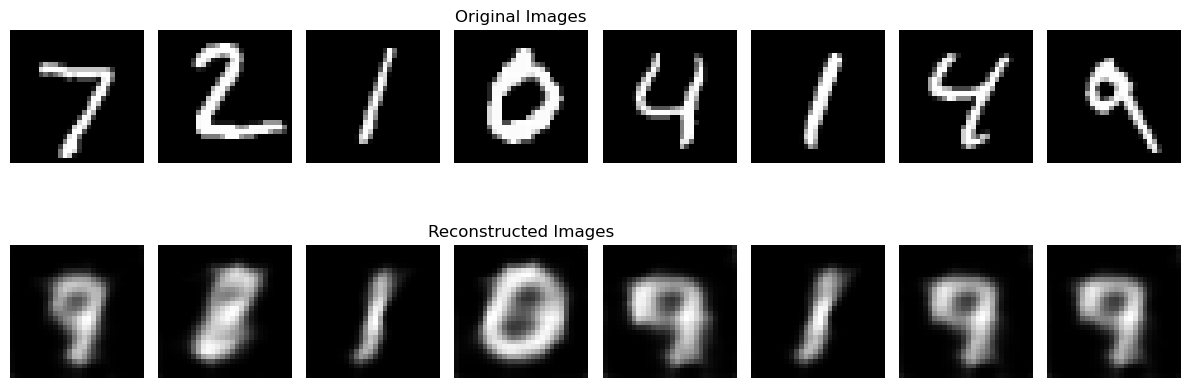

In [26]:
# Get some images from the test dataset
data_iter = iter(test_dl)
images, images_no_noise = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
regularized_autoencoder.eval()
with torch.no_grad():
    reconstructions = regularized_autoencoder(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(12, 5))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    # Reconstructed images
    ax = axes[1, i]
    ax.imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images')

    loss = criterion(reconstructions[i], images[i])
    print(f"Loss for image {i+1}: {loss.item()}")

plt.tight_layout()
plt.show()

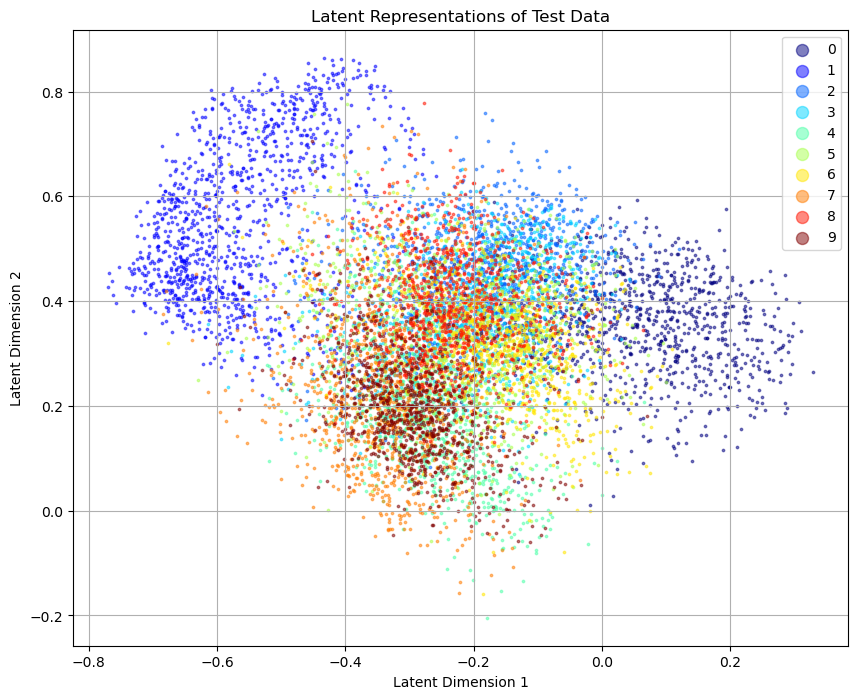

In [27]:
# Get the latent representations for all test data
latent_representations = []
labels_agg = []
digits = list(range(10))

mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(mnist_test_ds, batch_size=128)

regularized_autoencoder.eval()
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = regularized_autoencoder.encoder(images)
        latent_representations.append(latent_vectors.cpu().numpy())
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations = np.concatenate(latent_representations, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('jet', 10)
for d in digits:
    indices = np.where(labels_agg == d)
    plt.scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{d}",
        c=[cmap(d)],
        alpha=0.5,
    )
# add the labels mapping
plt.legend(markerscale=5)
plt.title('Latent Representations of Test Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()